# This notebook tries to find out thresholds for different methods based on their Dice scores

## This part is for our method (will need to change configs as we find better loss/arch etc.)

In [129]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import VesselTrainer
from utils import dir2flow_2d, v2vesselness, overlay, overlay_quiver
from sklearn import metrics as M
from copy import deepcopy
import pickle as pkl

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)


class Args:
    def __init__(self):
#         self.config = 'configs/drivemaskv2_scale8.json'
#         self.config = 'configs/toydrive.json'
        self.config = 'configs/mloss/drivesq4.json'
        self.resume = None
        self.run_id = ''
        self.device = None

args = Args()
IDX = 0

In [130]:
config = ConfigParser.from_args(args, '', parse=False)
# Augment some things here for dataloader
config.config['data_loader']['args']['augment'] = False
config.config['data_loader']['args']['validation_split'] = 0
config.config['data_loader']['args']['idx'] = IDX   # Use just one index

# config.config['optimizer']['args']['lr'] = 1e-2
# config.config['arch']['type'] = 'DeepLabV3'

data_loader = config.init_obj('data_loader', module_data)
config.config['data_loader']['args']['toy'] = True
gt_loader = config.init_obj('data_loader', module_data)

model = config.init_obj('arch', module_arch).cuda()
criterion = getattr(module_loss, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)


backup_config = deepcopy(config)


Preserving indices:  [0]
Preserving indices:  [0]


In [131]:
print(dict(config['loss_args']))
# Change loss args here
pass
# config.config['loss_args']['lambda_intensity'] = 1
# config.config['loss_args']['lambda_consistency'] = 1

{'num_directions': 2, 'eps': 0.1, 'uncertainty': False, 'loss_intensity': 'L2', 'lambda_intensity': 0.1, 'lambda_consistency': 0.2, 'lambda_cosine': 1, 'lambda_decoder': 1, 'lambda_length': 1, 'lambda_template': 5, 'is_crosscorr': True, 'use_mask': True, 'detach': True, 'num_samples_template': 12, 'lambda_followupv': 0, 'lambda_perlength': 0.1}


In [132]:
%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [133]:
def dice_score(a, b):
    num = (2*a*b).sum()
    den = a.sum() + b.sum()
    return num/den

In [134]:
auc_list = []

for data in gt_loader:
    gt = data['image']
    break

In [135]:
mask = data['mask'][0, 0].data.cpu().numpy()
g = gt[0, 0].data.cpu().numpy()
g = (g > 0.5).astype(float)

# Frangi

Here we'll try to determine the best threshold for Frangi in a similar way.

In [136]:
from skimage.filters import frangi

for data in data_loader:
    img = data['image'].data.cpu().numpy()[0, 0]
    break

In [137]:
frangives = frangi(img, np.linspace(1, 5, 10), black_ridges=True).astype(np.float32)*mask

In [138]:
# Get AUC here
fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), frangives.reshape(-1), pos_label=1)
auc = M.auc(fpr, tpr)
print(auc)

0.9481921363930657


In [139]:
dice = []
for t in thres:
    vthres = (frangives > t).astype(float)
    # Given thresholded image, get dice score
    d = dice_score(vthres, g)
    dice.append(d)

In [140]:
f_max_idx = np.argmax(dice)
f_max_thres = thres[max_idx]
f_max_d = dice[max_idx]
print("Maximum dice score: {} achieved at threshold = {}".format(f_max_d, f_max_thres))

Maximum dice score: 0.681187456712283 achieved at threshold = 2.838268358118512e-07


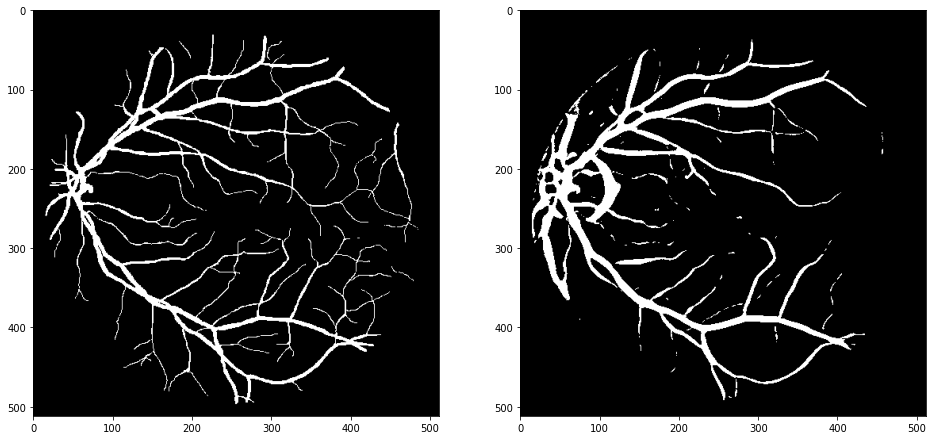

In [141]:
mask = data['mask'][0, 0].data.cpu().numpy()
g = gt[0, 0].data.cpu().numpy()
g = (g > 0.5).astype(float)

plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.imshow(g, 'gray')
plt.subplot(122)
plt.imshow(frangives > f_max_thres, 'gray')

--------------
# Vesselness from file

In [142]:
# with open('./drivec4_10.pkl', 'rb') as fi:
# with open('./drivesqcontrast8.pkl', 'rb') as fi:
# with open('./drive_sq8_300.pkl', 'rb') as fi:
# with open('drive_contrast8_525.pkl', 'rb') as fi:
with open('vesselness.pkl', 'rb') as fi:
    data_ = pkl.load(fi)
    data_ = (data_ - data_.min())/(data_.max() - data_.min())

0.951621058736571


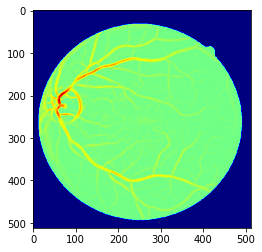

In [143]:
# Get AUC here
fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), (data_[IDX, 0] * mask).reshape(-1), pos_label=1)
auc = M.auc(fpr, tpr)
print(auc)

plt.imshow(data_[IDX, 0]*mask, 'jet')

In [144]:
dice = []
for t in thres:
    vthres = (data_[IDX, 0] * mask > t).astype(float)
    # Given thresholded image, get dice score
    d = dice_score(vthres, g)
    dice.append(d)

In [145]:
F_max_idx = np.argmax(dice)
F_max_thres = thres[max_idx]
F_max_d = dice[max_idx]
print("Maximum dice score: {} achieved at threshold = {}".format(F_max_d, F_max_thres))

Maximum dice score: 0.6420034149117815 achieved at threshold = 0.4796496033668518


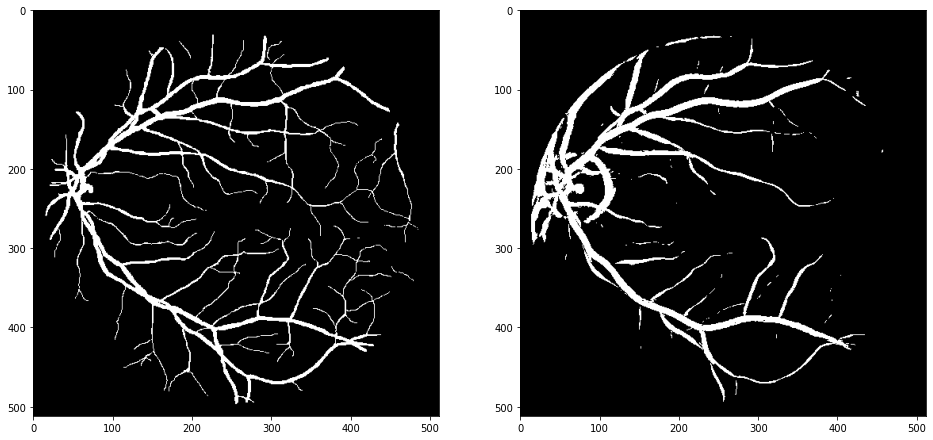

In [146]:
plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.imshow(g, 'gray')
plt.subplot(122)
plt.imshow(data_[IDX, 0]*mask > F_max_thres, 'gray')
# plt.imshow(data_[IDX, 0] > 0.23, 'gray')

In [147]:
# Frangi
frangiV = (frangives > f_max_thres).astype(int)
acc = (frangiV == g).mean()
tn = ((frangiV == 0)*(g == 0)).mean()
tp = ((frangiV == 1)*(g == 1)).mean()
fp = ((frangiV == 1)*(g == 0)).mean()
fn = 1 - tn - tp - fp
# other parameters 
print("Frangi Accuracy: {:4f}, Specificity: {:4f}, Sensitivity: {:4f}".format(acc, tn/(tn+fp), tp/(tp + fn)))
### Our method
ourV = (data_[IDX, 0]*mask > F_max_thres).astype(int)
acc = (ourV == g).mean()
tn = ((ourV == 0)*(g == 0)).mean()
tp = ((ourV == 1)*(g == 1)).mean()
fp = ((ourV == 1)*(g == 0)).mean()
fn = 1 - tn - tp - fp
# other parameters 
print("Ours   Accuracy: {:4f}, Specificity: {:4f}, Sensitivity: {:4f}".format(acc, tn/(tn+fp), tp/(tp + fn)))

Frangi Accuracy: 0.949078, Specificity: 0.967573, Sensitivity: 0.722076
Ours   Accuracy: 0.944813, Specificity: 0.968279, Sensitivity: 0.656810


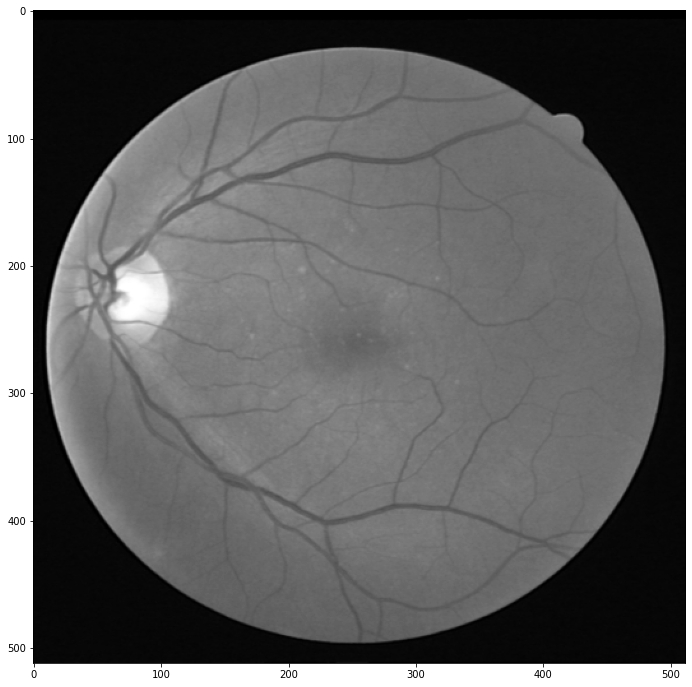

In [148]:
plt.figure(figsize=(12, 12))
plt.imshow(data['image'][0, 0], 'gray')


# CAUTION: Dont change this code [previous saved results]

In [ ]:
input('Are you sure?')

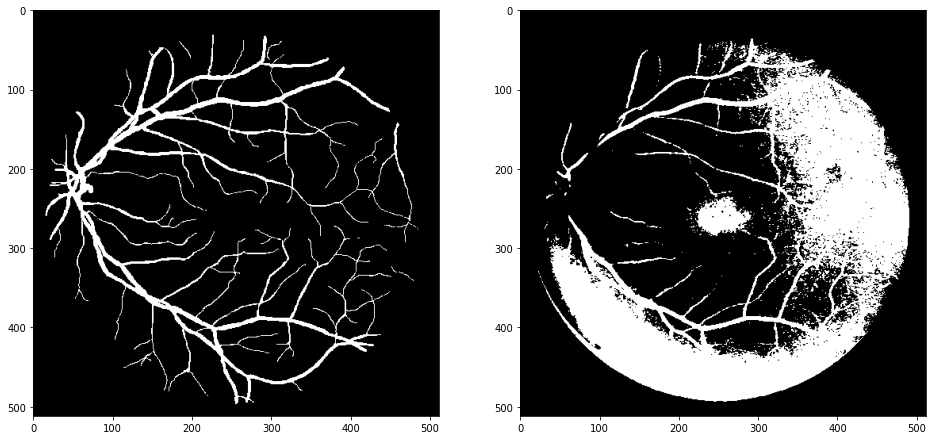

In [62]:
plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.imshow(g, 'gray')
plt.subplot(122)
plt.imshow(data_[IDX, 0]*mask > 0.55, 'gray')
# plt.imshow(data_[IDX, 0] > 0.23, 'gray')

------------------------------

# Collecting results here
## [CAUTION]

This part will have the threshold values from different runs, and we'll take an average of them.

In [ ]:
print(max_thres, f_max_thres)

In [ ]:
'''
BE CAREFUL with this part
'''
threshold_ours = [0.5308043956756592, 0.5867383480072021, 0.5557414889335632, 0.4445055425167084, 0.35897117853164673]
threshold_frangi = [4.14647615798458e-07, 2.9678446367142897e-07, 2.9782495403196663e-7, 5.255294581729686e-07, 3.860492370222346e-07]

In [ ]:
print("Mean threshold with our method: {}".format(np.mean(threshold_ours)))
print("Mean threshold with Frangi: {}".format(np.mean(threshold_frangi)))

In [53]:
'''
Run it for a single image
'''
def cuda(data):
    for k, v in data.items():
        data[k] = v.cuda()
    return data


def _train_epoch(epoch, gt=None, logepoch=100):
    """
    Training logic for an epoch

    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    # Get parameters for quiver
    params = config['trainer']
    normflow = params.get('normalize_flow', True)
    normflowrev = params.get('normalize_flow_rev', True)
    quiverscale = params.get('quiver_scale', 2)
    
    # Get vessel type here
    vessel_type = config.get('vessel_type', 'light')
    
    auc = 0
    model.train()
    for batch_idx, data in enumerate(data_loader):
        # Move tensors to device
        data = cuda(data)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data, config)
        loss.backward()
        optimizer.step()
        
        mask = data.get('mask')
        if mask is not None:
            mask = mask.cpu()         
        
        if gt is None:
            print("Epoch: {}, Loss: {}".format(epoch, loss.data.cpu().numpy()))
        else:
            ves = v2vesselness(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), \
               vtype=vessel_type, mask=mask, is_crosscorr=False)
            # Get auc value
            V = ves[0, 0].data.cpu().numpy()
            g = (gt[0, 0] > 0.5).data.cpu().numpy().astype(int)
            V = (V - V.min())/(V.max() - V.min())
            fpr, tpr, thres = M.roc_curve(g.reshape(-1), V.reshape(-1), pos_label=1)
            auc = M.auc(fpr, tpr)
            print("Epoch: {}, Loss: {:2f}, AUC: {:2f}".format(epoch, loss.data.cpu().numpy(), auc))            

        
    if (epoch+1) % logepoch == 0:
        # Get images to inspect
        q1 = overlay_quiver(data['image'].cpu(), output['vessel'][:, 0:2].cpu(), quiverscale, normflowrev)
        q2 = overlay_quiver(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), quiverscale, normflowrev)
        ves = v2vesselness(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), \
                           vtype=vessel_type, mask=mask, is_crosscorr=False)
    else:
        q1 = q2 = None

    return q1, q2, ves, auc